# Игры - Анализ рекламных источников

<b>Описание проекта, цель и задачи


Основной датасет содержит данные о событиях, совершенных в мобильной игре «Космические братья». В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.

Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно.

Цель:проанализировать поведение игроков в зависимости от источника перехода. 

Задачи:
   * Провести предобработку данных и декомпозицию
   * Разбить пользователей на когорты в зависимости от стратегии прохождения игры
   * Проанализировать влияние источника перехода на поведения игроков(сравнить нужные метрики)
   * Оценить уровень затрат и эффективность рекламных каналов
   * Оценить значимость

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np

##  Предобработка данных

### Открыть файлы с данными и изучить общую информацию

In [2]:
from io import BytesIO
import requests
spreadsheet_id = '1uW6nOMDSILe8vwMyUmkKNzO_qcoy5an8hFty5n7xCqU'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
ad_costs = pd.read_csv(BytesIO(r.content))

In [3]:
spreadsheet_id = '10dEeCHb0cA_XQn94Nt9uzF90WmVGHuZJFVZ_Yeb7HW0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
game_actions = pd.read_csv(BytesIO(r.content))

In [4]:
spreadsheet_id = '1gUycgtBNUqgnfH7wDf1ov-UQnN_uKtNPft45db_5xD4'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
user_source = pd.read_csv(BytesIO(r.content))

In [5]:
def review(df):
    print('---------------------------------')
    print('DESCRIBE')
    print('---------------------------------')
    print(df.describe()),
    print('---------------------------------')
    print('VALUE_COUNTS')
    print('---------------------------------')
    print(df.value_counts()),
    print('---------------------------------')
    print('INFO')
    print('---------------------------------')
    print(df.info()),
    print('---------------------------------')
    print('FRAME_HEAD')
    print('---------------------------------')
    print(df.head())

In [6]:
review(ad_costs)

---------------------------------
DESCRIBE
---------------------------------
             cost
count   28.000000
mean   271.556321
std    286.867650
min     23.314669
25%     66.747365
50%    160.056443
75%    349.034473
max    969.139394
---------------------------------
VALUE_COUNTS
---------------------------------
source                   day         cost      
facebook_ads             2020-05-03  935.882786    1
                         2020-05-04  548.354480    1
youtube_channel_reklama  2020-05-08  40.217907     1
                         2020-05-07  55.740645     1
                         2020-05-06  88.506074     1
                         2020-05-05  147.041741    1
                         2020-05-04  259.073224    1
                         2020-05-03  454.224943    1
yandex_direct            2020-05-09  42.779505     1
                         2020-05-08  62.961630     1
                         2020-05-07  114.429338    1
                         2020-05-06  180.917099  

In [7]:
review(game_actions)

---------------------------------
DESCRIBE
---------------------------------
             event_datetime     event building_type  \
count                135640    135640        127957   
unique               128790         3             3   
top     2020-05-09 12:35:56  building     spaceport   
freq                      4    127957         59325   

                                     user_id                project_type  
count                                 135640                        1866  
unique                                 13576                           1  
top     bf542075-e3a2-4e79-82d8-3838e86d2a25  satellite_orbital_assembly  
freq                                      22                        1866  
---------------------------------
VALUE_COUNTS
---------------------------------
Series([], dtype: int64)
---------------------------------
INFO
---------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (t

In [8]:
review(user_source)

---------------------------------
DESCRIBE
---------------------------------
                                     user_id         source
count                                  13576          13576
unique                                 13576              4
top     0001f83c-c6ac-4621-b7f0-8a28b283ac30  yandex_direct
freq                                       1           4817
---------------------------------
VALUE_COUNTS
---------------------------------
user_id                               source                 
0001f83c-c6ac-4621-b7f0-8a28b283ac30  facebook_ads               1
a9ff93bd-0b96-4e89-bef7-c29326643faf  youtube_channel_reklama    1
aa08dc9a-f199-483d-aa43-2781abb889fc  instagram_new_adverts      1
aa0d0a62-0ba5-4d87-9467-4eb39d6b2d17  facebook_ads               1
aa122ae2-5e98-4d93-96dc-fdcf7016398e  facebook_ads               1
                                                                ..
53c5f5cc-975b-4be6-9a60-2a8fe0fc226f  instagram_new_adverts      1
53d146cf-1b

### Проверить форматы данных и привести их к нужному если необходимо

In [9]:
game_actions.dtypes

event_datetime    object
event             object
building_type     object
user_id           object
project_type      object
dtype: object

In [10]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 0:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 0:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 0:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 0:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 0:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [11]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

In [12]:
ad_costs.dtypes

source     object
day        object
cost      float64
dtype: object

In [13]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

In [14]:
user_source.dtypes

user_id    object
source     object
dtype: object

### Проверить на пропуски

In [15]:
for i in [game_actions, ad_costs, user_source]:
    result = i.isna().sum()
    print(result)

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64
source    0
day       0
cost      0
dtype: int64
user_id    0
source     0
dtype: int64


Пропуски можно заменить на категориальное значение "no building" для признака 'buildung_type'. Вполне логично, что тип постройки определяется только для события building. Это технический пропуск вызванный особенностью сбора данных. В ходе дальнейшей работы над проектом было принято решение оставить пропуски так как замена на категориальные значения мешает необходимым расчетам и проверке гипотез.

Пропуски в 'project_type' тоже технические так как тип проекта на первом уровне игры только один и присваевается для события project. Эти пропуски можно тоже заменить на категорию. Например на 'not project'

In [16]:
game_actions.isna().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

### Проверить на дубликаты

In [17]:
game_actions.duplicated().sum()

1

In [18]:
game_actions.drop_duplicates(inplace=True)

###  Преобразовать и объединить датасеты

Далее для дальнейшего удобства анализа нужно объединить датасеты и провести необходимые группировки 

In [19]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [20]:
game_actions['event_datetime'].min()

Timestamp('2020-05-04 00:00:01')

In [21]:
game_actions['event_datetime'].max()

Timestamp('2020-06-05 12:32:49')

В базе данных на одного уникального пользователя может приходится несколько событий 

In [22]:
game_actions['user_id'].nunique()

13576

In [23]:
actions_source = game_actions.merge(user_source, on='user_id', how='left')

Теперь мы знаем с какого рекламного канала пришел тот или иной пользователь 

In [24]:
actions_source.isna().sum() # Ничего не потеряли 

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133773
source                 0
dtype: int64

In [25]:
actions_source['day'] = actions_source['event_datetime'].dt.date
actions_source['day'] = pd.to_datetime(actions_source['day'])

In [26]:
actions_source.groupby(['source'])['user_id'].nunique() #Число уникальных пользователей в разбивке по каналам за весь период 

source
facebook_ads               2726
instagram_new_adverts      3347
yandex_direct              4817
youtube_channel_reklama    2686
Name: user_id, dtype: int64

Если считать, что первое действие пользователя следует сразу за привлечением , то проследить динамику привлечения пользователей по дням для разных каналов можно преобразовав данные следующим образом

In [27]:
user_source_cost = actions_source.groupby(['user_id','source'], as_index=False)['day'].min().merge(ad_costs, on=['day', 'source'], how='left')

In [28]:
user_source_cost.groupby(['day','source','cost'], as_index=False)['user_id'].nunique()

,day,source,cost,user_id
0,2020-05-04,facebook_ads,548.354480,1184
1,2020-05-04,instagram_new_adverts,502.925451,1452
2,2020-05-04,yandex_direct,554.651494,2078
3,2020-05-04,youtube_channel_reklama,259.073224,1146
4,2020-05-05,facebook_ads,260.185754,694
5,2020-05-05,instagram_new_adverts,313.970984,796
6,2020-05-05,yandex_direct,308.232990,1208
7,2020-05-05,youtube_channel_reklama,147.041741,663
8,2020-05-06,facebook_ads,177.982200,345
9,2020-05-06,instagram_new_adverts,173.071145,472


Думаю, что лучше оставить две таблицы для дальнейшего анализа:
* actions_source с данными о действиях игроков и метками о каналах с которых они были привлечены. В дальнейшем эта таблица понадобится для проверки второй гипотезы об отличиях характера привлечения игроков с разными игровыми стратегиями  для разных каналов трафика. 
* user_source_cost поможет оценить затраты на привлечение 

### Разбить пользователей на когорты по условным признакам(стратегия игрового поведения)

Пользовтелей игры можно разделить на две категории:
* Исследователи. Это те, кто предпочел строительство и выполнение исследовательского проекта для прохождения первого уровня
* Воители. Это те, кто прошел уровень, сразившись с первым врагом.
* Также есть те пользователи, которые еще не прошли уровень

In [29]:
actions_source_by_events = actions_source.groupby('user_id', as_index=False)['event'].agg(['unique']).reset_index()

In [30]:
def row(df):
    if 'building' in df['unique'] and 'project' in df['unique'] and 'finished_stage_1' in df['unique']:
        return 'explorer'
    if 'building' in df['unique'] and 'finished_stage_1' in df['unique']:
        return 'warrior'
    else:
        return 'unfinished_stage_1'

In [31]:
actions_source_by_events['game_strategy'] = actions_source_by_events.apply(row, axis=1)
actions_source_by_events = actions_source_by_events.drop(['unique'], axis=1)

In [32]:
actions_source_strategy = actions_source.merge(actions_source_by_events, on='user_id', how='left')

In [33]:
actions_source_strategy.isna().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133773
source                 0
day                    0
game_strategy          0
dtype: int64

Теперь мы знаем откуда пришли наши пользователи и какой игровой стратегии придерживались,а также завершили ли вообще уровень к моменту исследования 

<b>Вывод:</b>  На данном этапе была проведена предворительная работа над данными. Данные были приведены к нужным форматам, проверены на пропуски и дубликаты, а также декомпозированы для удобства дальнейшего анализа. В итоге было принято решение составить два базовых датасета.

## EDA

### Оценить количество пользователей по источникам перехода

In [34]:
actions_source_strategy.groupby('source', as_index=False)['user_id'].nunique()

,source,user_id
0,facebook_ads,2726
1,instagram_new_adverts,3347
2,yandex_direct,4817
3,youtube_channel_reklama,2686


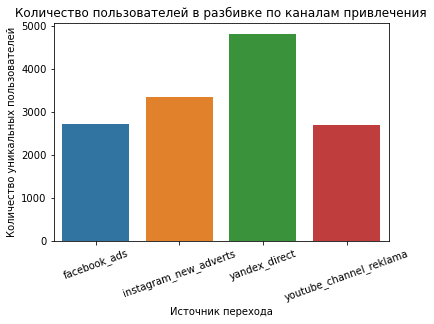

In [35]:
sns.barplot(x=actions_source_strategy.groupby('source', as_index=False)['user_id'].nunique()['source'], y=actions_source_strategy.groupby('source', as_index=False)['user_id'].nunique()['user_id'])
plt.title('Количество пользователей в разбивке по каналам привлечения')
plt.xticks(rotation=20)
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Источник перехода')
plt.show()

Больше всего пользователей пришло с Яндекс.Директ

### Оценить активность пользователей в зависимости от источника перехода 

In [36]:
actions_source_strategy.groupby('source', as_index=False)['event'].count()

,source,event
0,facebook_ads,27672
1,instagram_new_adverts,33757
2,yandex_direct,47694
3,youtube_channel_reklama,26516


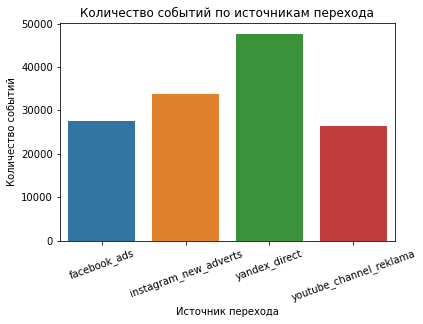

In [37]:
sns.barplot(x=actions_source_strategy.groupby('source', as_index=False)['event'].count()['source'], y=actions_source_strategy.groupby('source', as_index=False)['event'].count()['event'])
plt.title('Количество событий по источникам перехода')
plt.xticks(rotation=20)
plt.ylabel('Количество событий')
plt.xlabel('Источник перехода')
plt.show()

График повторяет предыдущий, что логично. Чем больше пользователей,тем больше действий совершено в итоге.

In [38]:
actions_source_strategy.groupby('source', as_index=False)['event'].count()

,source,event
0,facebook_ads,27672
1,instagram_new_adverts,33757
2,yandex_direct,47694
3,youtube_channel_reklama,26516


Можно оценить сколько в среднем событий приходится на одного пользователя

In [39]:
event_on_user = (actions_source_strategy.groupby('source', as_index=False)['user_id'].nunique().merge
(actions_source_strategy.groupby('source', as_index=False)['event'].count(), on='source', how='left'))
event_on_user['event_on_user'] = (event_on_user['event'] / event_on_user['user_id']).round(2)
event_on_user

,source,user_id,event,event_on_user
0,facebook_ads,2726,27672,10.15
1,instagram_new_adverts,3347,33757,10.09
2,yandex_direct,4817,47694,9.90
3,youtube_channel_reklama,2686,26516,9.87


В среднем пользователи совершают примерно одинаковое количество действий, несмотря на то,что выборки разные по количеству пользователей

Можно оценить как отличаются уровни вовлеченности пользователей в игру в зависимости от источника перехода. Для этого можно сравнить доли прошедших уровень до конца в разбивке по каналам привлечения.

In [40]:
users_finished_stage_1 = actions_source_strategy.query('game_strategy != "unfinished_stage_1"')

In [41]:
share_finished_stage_1 = (users_finished_stage_1.groupby('source', as_index=False)['user_id'].nunique().merge
 (actions_source_strategy.groupby('source', as_index=False)['user_id'].nunique(), on='source', how='outer'))
share_finished_stage_1.columns = ['source', 'users_finished_stage', 'users_total']
share_finished_stage_1['share_of_total'] = (share_finished_stage_1['users_finished_stage'] / share_finished_stage_1['users_total']).round(2)
share_finished_stage_1

,source,users_finished_stage,users_total,share_of_total
0,facebook_ads,1150,2726,0.42
1,instagram_new_adverts,1466,3347,0.44
2,yandex_direct,2042,4817,0.42
3,youtube_channel_reklama,1159,2686,0.43


Можно заметить, что процент пользователей прошедших уровень примерно одинаков для всех каналов привлечения. Немного опережают по показателю только пользователи, привлеченные через канал instagram_new_adverts 	

Эти средние значения логичным образом близки  среднему общему

In [42]:
print('Доля прошедших уровень пользователей:', round(users_finished_stage_1['user_id'].nunique() / actions_source['user_id'].nunique(), 2))

Доля прошедших уровень пользователей: 0.43


In [43]:
actions_source_strategy.groupby('user_id', as_index=False)['event'].nunique().mean() # В среднем пользователи совершали полтора уникальных действия

C:\Users\Vittorio\AppData\Local\Temp/ipykernel_10808/3955615276.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  actions_source_strategy.groupby('user_id', as_index=False)['event'].nunique().mean() # В среднем пользователи совершали полтора уникальных действия


event    1.565925
dtype: float64

### Оценить соотношение пользователей в зависимости от игрового поведения

In [44]:
actions_source_strategy.groupby('game_strategy', as_index=False)['user_id'].nunique()

,game_strategy,user_id
0,explorer,1866
1,unfinished_stage_1,7759
2,warrior,3951


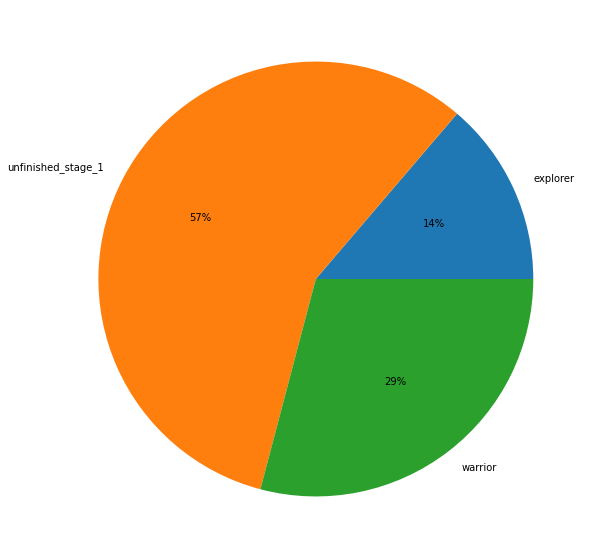

In [45]:
plt.figure(figsize=(10,10))
plt.pie(actions_source_strategy.groupby('game_strategy', as_index=False)['user_id'].nunique()['user_id'], labels=actions_source_strategy.groupby('game_strategy', as_index=False)['user_id'].nunique()['game_strategy'], autopct='%.0f%%')
plt.show()

Как можно увидеть среди 43% пользователей прошедших уровень, 29% оказались воинами по стратегии прохождения, а 14% исследователями. Похоже динамичность привлекает пользователей больше

### Оценить для каких типов игрового поведения какие источники перехода характерны

In [46]:
actions_source_strategy.head()

,event_datetime,event,building_type,user_id,project_type,source,day,game_strategy
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,unfinished_stage_1
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,explorer
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,warrior
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,unfinished_stage_1
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,warrior


In [47]:
share_by_strategy = actions_source_strategy.groupby(['game_strategy','source'], as_index=False)['user_id'].nunique().merge(actions_source_strategy.groupby(['game_strategy'], as_index=False)['user_id'].nunique(), on='game_strategy', how='left')
share_by_strategy.columns = ['game_strategy','source','users_by_channel','users_total'] 
share_by_strategy['share_of_total'] = (share_by_strategy['users_by_channel'] / share_by_strategy['users_total']).round(2)
share_by_strategy

,game_strategy,source,users_by_channel,users_total,share_of_total
0,explorer,facebook_ads,391,1866,0.21
1,explorer,instagram_new_adverts,476,1866,0.26
2,explorer,yandex_direct,620,1866,0.33
3,explorer,youtube_channel_reklama,379,1866,0.20
4,unfinished_stage_1,facebook_ads,1576,7759,0.20
5,unfinished_stage_1,instagram_new_adverts,1881,7759,0.24
6,unfinished_stage_1,yandex_direct,2775,7759,0.36
7,unfinished_stage_1,youtube_channel_reklama,1527,7759,0.20
8,warrior,facebook_ads,759,3951,0.19
9,warrior,instagram_new_adverts,990,3951,0.25


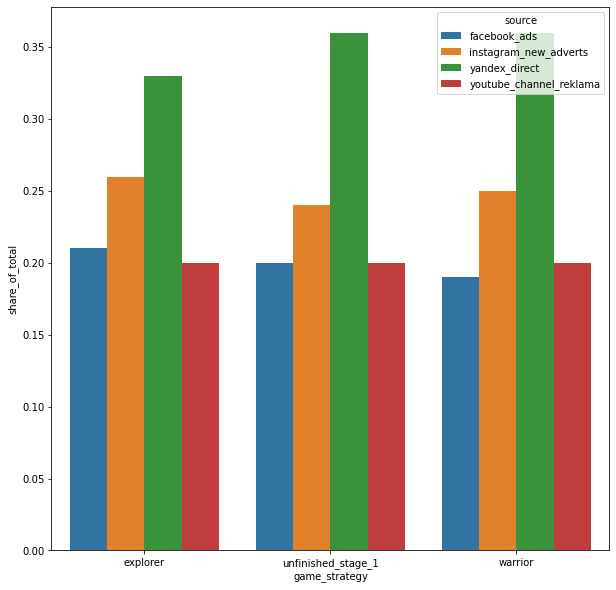

In [48]:
plt.figure(figsize=(10,10))
sns.barplot(x='game_strategy', y='share_of_total', hue='source', data=share_by_strategy)
plt.show()

In [49]:
dist_source = share_by_strategy.query('game_strategy == "explorer"').drop('game_strategy', axis=1).merge(share_by_strategy.query('game_strategy == "warrior"').drop('game_strategy', axis=1), on='source')

In [50]:
dist_source.columns = ['source','explorer', 'explorer_total', 'share_channel_exp', 'warrior', 'warrior_total','share_channel_war']
dist_source['explorer_to_warrior'] = dist_source['explorer'] / dist_source['warrior']
dist_source['warrior_plus_explorer_total'] = dist_source['explorer_total']+dist_source['warrior_total']
dist_source['percent_exp'] = dist_source['explorer'] / dist_source['warrior_plus_explorer_total']
dist_source['percent_war'] = dist_source['warrior'] / dist_source['warrior_plus_explorer_total']
dist_source

,source,explorer,explorer_total,share_channel_exp,warrior,warrior_total,share_channel_war,explorer_to_warrior,warrior_plus_explorer_total,percent_exp,percent_war
0,facebook_ads,391,1866,0.21,759,3951,0.19,0.515152,5817,0.067217,0.130480
1,instagram_new_adverts,476,1866,0.26,990,3951,0.25,0.480808,5817,0.081829,0.170191
2,yandex_direct,620,1866,0.33,1422,3951,0.36,0.436006,5817,0.106584,0.244456
3,youtube_channel_reklama,379,1866,0.20,780,3951,0.20,0.485897,5817,0.065154,0.134090


Воителей привлекается больше на всех каналах. Как правило характерное соотношение исследователей к воителям примерно 1/2. Для yandex_direct присутствует небольшой перевес в сторону воителей. Т.е. пропорционально для этого канала характерно привлекать чуть больше воителей,чем для остальных каналов. Но речь лишь о единицах процентов.

### Оценить затраты на привелечение пользователей

In [51]:
user_unique_source_cost = user_source_cost.groupby(['day','source','cost'], as_index=False)['user_id'].nunique()
user_unique_source_cost['CAC'] = user_unique_source_cost['cost'] / user_unique_source_cost['user_id']
user_unique_source_cost

,day,source,cost,user_id,CAC
0,2020-05-04,facebook_ads,548.354480,1184,0.463137
1,2020-05-04,instagram_new_adverts,502.925451,1452,0.346367
2,2020-05-04,yandex_direct,554.651494,2078,0.266916
3,2020-05-04,youtube_channel_reklama,259.073224,1146,0.226067
4,2020-05-05,facebook_ads,260.185754,694,0.374907
5,2020-05-05,instagram_new_adverts,313.970984,796,0.394436
6,2020-05-05,yandex_direct,308.232990,1208,0.255160
7,2020-05-05,youtube_channel_reklama,147.041741,663,0.221782
8,2020-05-06,facebook_ads,177.982200,345,0.515890
9,2020-05-06,instagram_new_adverts,173.071145,472,0.366676


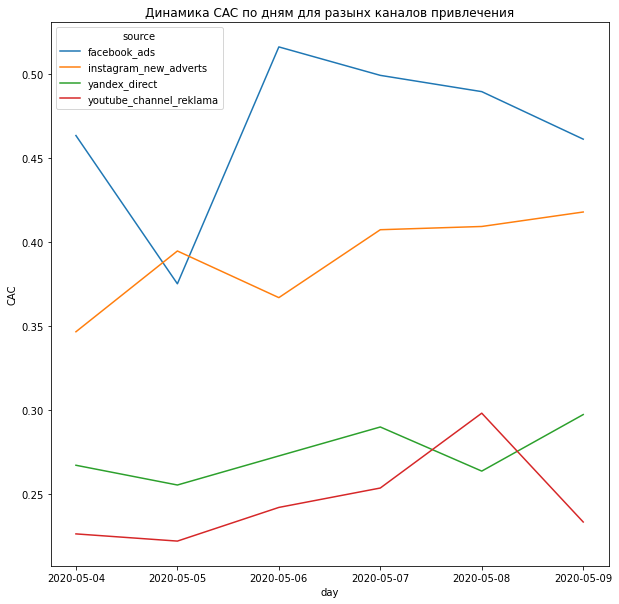

In [52]:
plt.figure(figsize=(10,10))
plt.title('Динамика CAC по дням для разынх каналов привлечения')
sns.lineplot(data=user_unique_source_cost, x='day', y='CAC', hue='source')
plt.show()

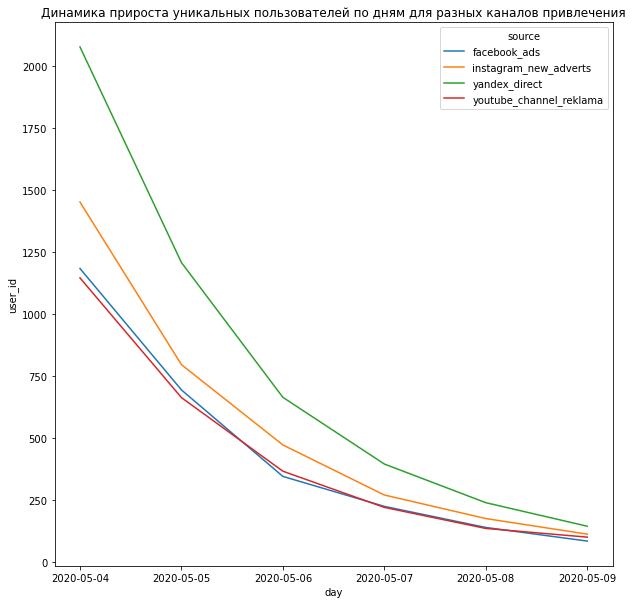

In [53]:
plt.figure(figsize=(10,10))
plt.title('Динамика прироста уникальных пользователей по дням для разных каналов привлечения')
sns.lineplot(data=user_unique_source_cost, x='day', y='user_id', hue='source')
plt.show()

In [54]:
user_unique_source_cost_total = user_unique_source_cost.groupby('source', as_index=False)['cost','user_id'].agg('sum')
user_unique_source_cost_total

C:\Users\Vittorio\AppData\Local\Temp/ipykernel_10808/1038298334.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_unique_source_cost_total = user_unique_source_cost.groupby('source', as_index=False)['cost','user_id'].agg('sum')


,source,cost,user_id
0,facebook_ads,1205.021857,2670
1,instagram_new_adverts,1218.236973,3277
2,yandex_direct,1263.972055,4728
3,youtube_channel_reklama,613.894261,2630


In [55]:
user_unique_source_cost_total['cost_per_user'] = user_unique_source_cost_total['cost'] / user_unique_source_cost_total['user_id']
user_unique_source_cost_total

,source,cost,user_id,cost_per_user
0,facebook_ads,1205.021857,2670,0.451319
1,instagram_new_adverts,1218.236973,3277,0.371754
2,yandex_direct,1263.972055,4728,0.267338
3,youtube_channel_reklama,613.894261,2630,0.233420


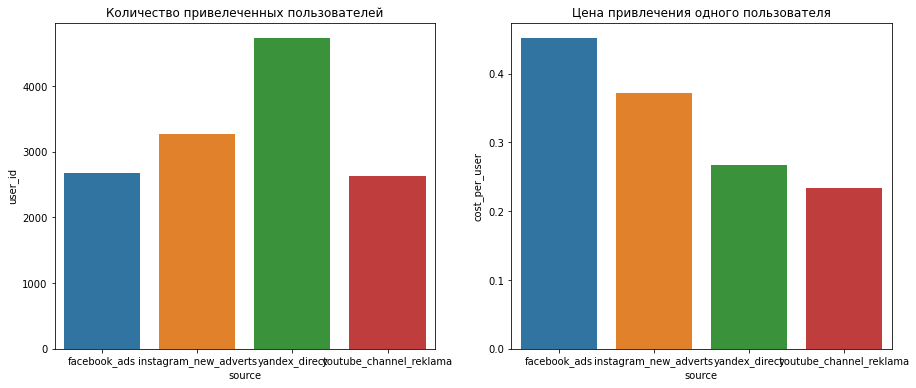

In [56]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title('Количество привелеченных пользователей')
sns.barplot(data=user_unique_source_cost_total,x='source', y='user_id')
plt.subplot(1,2,2)
plt.title('Цена привлечения одного пользователя')
sns.barplot(data=user_unique_source_cost_total,x='source', y='cost_per_user')
plt.show()

Можно сделать вывод о том, что лучше всего с задачей привлечения пользоватлей справляется Яндекс.Директ. Этот канал привлек больше всего пользователей, а цена привлечения для этого канала сравнительно низкая по сравнению с остальными. Фейсбук показал себя хуже всех, така как привлек мало пользователей, а затраты на этот канал привлечения достаточно высоки по сравнению с тем же Яндекс.Директом.

<b>Выводы по этапу:</b>
* Больше всего пользователей пришло с Яндекс.Директ
* В среднем пользователи, привлеченные с разных источников совершают примерно одинаковое количество действий(около 10), несмотря на то,что выборки разные по количеству пользователей. Т.е. количество действий пользователей в игре не зависит от того с какого источника они пришли.
* Можно заметить, что процент пользователей прошедших уровень примерно одинаков для всех каналов привлечения. Немного опережают по показателю только пользователи, привлеченные через канал instagram_new_adverts. Для этого канала доля пользователей прошедших уровень равна 44%.
* Уровень прошли 43% пользователей от общего числа пользователей.  29%  от общего числа пользователей оказались воинами по стратегии прохождения, а 14% исследователями. Похоже динамичность привлекает пользователей больше
* Воителей привлекается больше на всех каналах. Как правило характерное соотношение исследователей к воителям примерно 1/2. Для yandex_direct присутствует небольшой перевес в сторону воителей. Т.е. пропорционально для этого канала характерно привлекать чуть больше воителей,чем для остальных каналов. Но речь лишь о единицах процентов.
* Можно сделать вывод о том, что лучше всего с задачей привлечения пользоватлей справляется Яндекс.Директ. Этот канал привлек больше всего пользователей, а цена привлечения для этого канала сравнительно низкая по сравнению с остальными. Фейсбук показал себя хуже всех, така как привлек мало пользователей, а затраты на этот канал привлечения достаточно высоки по сравнению с тем же Яндекс.Директом.

## Статистическая проверка гипотез

### Проверить гипотезу о том, что время прохождения уровня различается в зависимости от способа прохождения c помощью T-теста

Чтобы провести тест нужно подготовить данные

In [58]:
start_stage_time = users_finished_stage_1.groupby(['user_id','game_strategy'], as_index=False)['event_datetime'].min()
start_stage_time.columns = ['user_id', 'game_strategy', 'start_stage']
finish_stage_time = users_finished_stage_1.groupby(['user_id','game_strategy'], as_index=False)['event_datetime'].max()
finish_stage_time.columns = ['user_id', 'game_strategy', 'finish_stage']
duration_of_stage = start_stage_time.merge(finish_stage_time, on=['user_id','game_strategy'], how='left')
duration_of_stage

,user_id,game_strategy,start_stage,finish_stage
0,001d39dc-366c-4021-9604-6a3b9ff01e25,warrior,2020-05-05 21:02:05,2020-05-12 07:40:47
1,003ee7e8-6356-4286-a715-62f22a18d2a1,warrior,2020-05-05 08:31:04,2020-05-17 21:47:49
2,004074f8-251a-4776-922c-8348dca1a2f6,warrior,2020-05-04 01:07:35,2020-05-16 19:57:40
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,warrior,2020-05-04 08:35:29,2020-05-15 16:02:01
4,0056c007-c082-43cc-bdef-afc49bca4cb9,warrior,2020-05-10 11:49:47,2020-05-16 13:48:39
...,...,...,...,...
5812,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,warrior,2020-05-06 06:34:18,2020-05-19 04:03:24
5813,ffe810f4-1a1f-464b-924d-6f120b0cb8df,warrior,2020-05-04 17:46:05,2020-05-18 02:03:36
5814,ffef4fed-164c-40e1-bde1-3980f76d0fb5,warrior,2020-05-04 01:58:59,2020-05-11 22:15:54
5815,fffb626c-5ab6-47c9-8113-2062a2f18494,warrior,2020-05-04 02:05:09,2020-05-12 13:01:52


In [59]:
duration_of_stage['duration'] = duration_of_stage['finish_stage'] - duration_of_stage['start_stage']
duration_of_stage['duration_in_minutes'] = duration_of_stage['duration'].dt.total_seconds().div(60).astype(float).round(1)

In [60]:
duration_of_stage.query('game_strategy == "warrior"')['duration_in_minutes'].mean()

15990.401872943585

In [61]:
duration_of_stage.query('game_strategy == "explorer"')['duration_in_minutes'].mean()

19380.82036441584

In [62]:
duration_of_stage.query('game_strategy == "warrior"')

,user_id,game_strategy,start_stage,finish_stage,duration,duration_in_minutes
0,001d39dc-366c-4021-9604-6a3b9ff01e25,warrior,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,9278.7
1,003ee7e8-6356-4286-a715-62f22a18d2a1,warrior,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45,18076.8
2,004074f8-251a-4776-922c-8348dca1a2f6,warrior,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05,18410.1
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,warrior,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32,16286.5
4,0056c007-c082-43cc-bdef-afc49bca4cb9,warrior,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52,8758.9
...,...,...,...,...,...,...
5811,ffc6f4fa-3476-47af-85cb-e2ee0551110a,warrior,2020-05-04 03:59:12,2020-05-15 12:18:42,11 days 08:19:30,16339.5
5812,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,warrior,2020-05-06 06:34:18,2020-05-19 04:03:24,12 days 21:29:06,18569.1
5813,ffe810f4-1a1f-464b-924d-6f120b0cb8df,warrior,2020-05-04 17:46:05,2020-05-18 02:03:36,13 days 08:17:31,19217.5
5814,ffef4fed-164c-40e1-bde1-3980f76d0fb5,warrior,2020-05-04 01:58:59,2020-05-11 22:15:54,7 days 20:16:55,11296.9


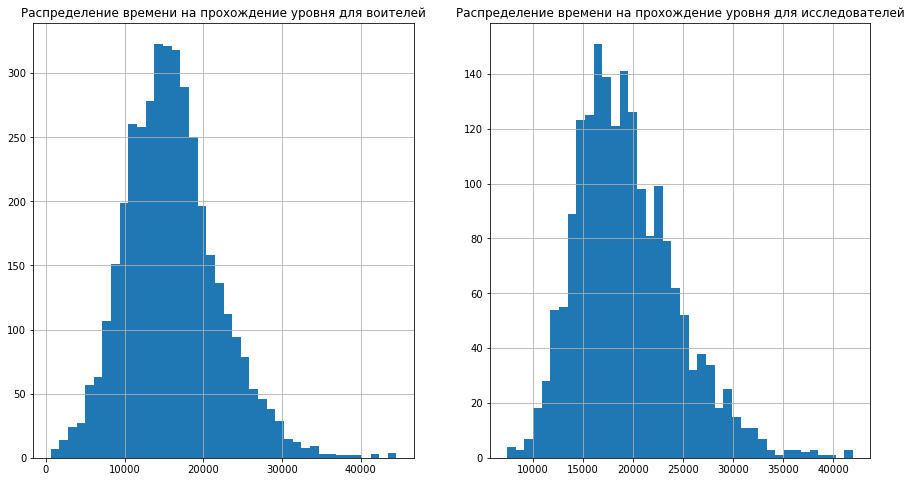

In [63]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.title('Распределение времени на прохождение уровня для воителей')
duration_of_stage.query('game_strategy == "warrior"')['duration_in_minutes'].hist(bins=40)
plt.subplot(1,2,2)
plt.title('Распределение времени на прохождение уровня для исследователей')
duration_of_stage.query('game_strategy == "explorer"')['duration_in_minutes'].hist(bins=40)
plt.show()

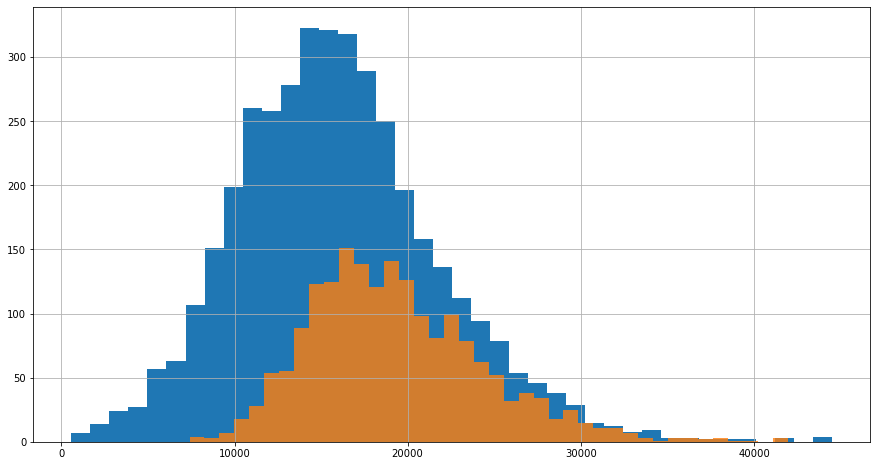

In [64]:
plt.figure(figsize=(15,8))
duration_of_stage.query('game_strategy == "warrior"')['duration_in_minutes'].hist(bins=40)
duration_of_stage.query('game_strategy == "explorer"')['duration_in_minutes'].hist(bins=40, alpha=0.8)
plt.show()

Размеры выборок значительно отличаются. Для проведения теста нужно свести выборки к одинаковому размеру. Также нужно предварительно избавиться от выбросов. 

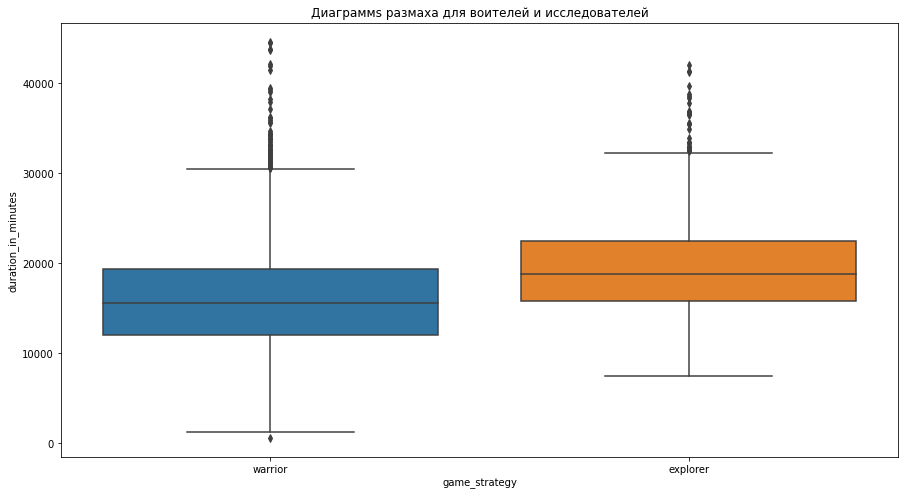

In [66]:
plt.figure(figsize=(15,8))
plt.title('Диаграммs размаха для воителей и исследователей')
sns.boxplot(x=duration_of_stage['game_strategy'], y=duration_of_stage['duration_in_minutes'])
plt.show()

In [67]:
np.percentile(duration_of_stage.query('game_strategy == "warrior"')['duration_in_minutes'], 99)

32172.4

In [68]:
np.percentile(duration_of_stage.query('game_strategy == "explorer"')['duration_in_minutes'], 99)

33353.65999999999

In [69]:
warrior_for_test = duration_of_stage.query('game_strategy == "warrior" and duration_in_minutes < 32172.4')
explorer_for_test = duration_of_stage.query('game_strategy == "explorer" and duration_in_minutes < 33353.6')

Теперь можно взять равные случайные выборки

Предварительно видно,что средние выборок отличаются. Осталось проверить статистически значимо ли они отличаются

In [70]:
warrior_for_test.sample(1800)['duration_in_minutes'].mean()

15836.296388888926

In [71]:
explorer_for_test.sample(1800)['duration_in_minutes'].mean()

19215.40444444445

In [72]:
warrior_for_test_sample = warrior_for_test.sample(1800)
explorer_for_test_sample = explorer_for_test.sample(1800)

Если мы будем неоднократно извлекать выборки одинакового размера из нашего массива, то их средние распределятся нормально вокруг среднего значения массива(генеральной совокупности). Это одинаково справедливо для массива значений воителей и исследователей. Поэтому Т-тест должен сработать корректно. Кроме того, значения средних мы уже знаем и можем проверить выводы теста.

Проведем тест

<p>H0: время завершения уровня не различается в зависимости способа прохождения
<p>Н1: время завершения уровня различается в зависимости способа прохождения

In [73]:
alpha = .05
results = st.ttest_ind(
    warrior_for_test_sample['duration_in_minutes'], 
    explorer_for_test_sample['duration_in_minutes'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 5.2741176300545255e-84
Отвергаем нулевую гипотезу


Вывод: Время прохождения уровня действительно статистически значимо отличается в зависимости от способа прохождения. Если ориентироваться на средние значения выборок, то можно сказать, что исследователям требуется больше времени, чтобы пройти уровень чем воинам

<b>Гипотеза: Среднее количество событий отличается в зависимости от способа прохождения

In [74]:
exp_event_count = users_finished_stage_1.query('game_strategy == "explorer"').groupby('user_id', as_index=False)['event'].count()
war_event_count = users_finished_stage_1.query('game_strategy == "warrior"').groupby('user_id', as_index=False)['event'].count()

In [77]:
exp_event_count['event'].mean()

14.64790996784566

In [78]:
war_event_count['event'].mean()

10.411541381928625

Предварительно можно сказать, что исследователи чаще инициируют игровые события. 

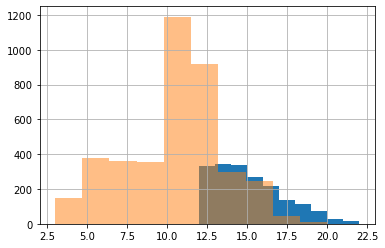

In [79]:
exp_event_count['event'].hist()
war_event_count['event'].hist(alpha=0.5)
plt.show()

In [80]:
np.percentile(war_event_count['event'], 99.99)

20.0

In [81]:
np.percentile(exp_event_count['event'], 99)

20.0

In [82]:
exp_event_count = exp_event_count.query('event < 20')
war_event_count = war_event_count.query('event < 20')

In [83]:
alpha = .05
results = st.ttest_ind(
    war_event_count['event'].sample(1800), 
    exp_event_count['event'].sample(1800))

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.0
Отвергаем нулевую гипотезу


В количестве игровых событий между выборками есть разница

<b>Вывод:</b> На данном этапе была проведена статистическая проверка гипотез в результате которой было выявлено, что  время прохождения уровня действительно статистически значимо отличается в зависимости от способа прохождения. Если ориентироваться на средние значения выборок, то можно сказать, что исследователям требуется больше времени, чтобы пройти уровень чем воинам.В количестве игровых событий между воинами и  исследователями есть разница. На исследователей приходится больше событий.

## Общий вывод и рекомендации

В результате исследования были сделаны следующие выводы:
* Больше всего пользователей пришло с источника Яндекс.Директ
* В среднем пользователи, привлеченные с разных источников совершают примерно одинаковое количество действий(около 10), несмотря на то,что выборки разные по количеству пользователей. Т.е. количество действий пользователей в игре не зависит от того с какого источника они пришли.
* Можно заметить, что процент пользователей прошедших уровень примерно одинаков для всех каналов привлечения. Немного опережают по показателю только пользователи, привлеченные через канал instagram_new_adverts. Для этого канала доля пользователей прошедших уровень равна 44%.
* Уровень прошли 43% пользователей от общего числа пользователей.  29%  от общего числа пользователей оказались воинами по стратегии прохождения, а 14% исследователями. Похоже динамичность привлекает пользователей больше
* Воителей привлекается больше на всех каналах. Как правило характерное соотношение исследователей к воителям примерно 1/2. Для yandex_direct присутствует небольшой перевес в сторону воителей. Т.е. пропорционально для этого канала характерно привлекать чуть больше воителей,чем для остальных каналов. Но речь лишь о единицах процентов.
* Можно сделать вывод о том, что лучше всего с задачей привлечения пользоватлей справляется Яндекс.Директ. Этот канал привлек больше всего пользователей, а цена привлечения для этого канала сравнительно низкая по сравнению с остальными. Фейсбук показал себя хуже всех, така как привлек мало пользователей, а затраты на этот канал привлечения достаточно высоки по сравнению с тем же Яндекс.Директом.
* Время прохождения уровня действительно статистически значимо отличается в зависимости от способа прохождения. Если ориентироваться на средние значения выборок, то можно сказать, что исследователям требуется больше времени, чтобы пройти уровень чем воинам.
* В количестве игровых событий между воинами и  исследователями есть статистически значимая разница. На исследователей приходится больше событий.

<b><p>Из этого следует, что наиболее эффективным каналом для привлечения пользователей стоит рассматривать Яндекс.Директ, так как соотношение затрат и привлекаемых пользователей в нем наиболее оптимальное. От рекламы через фейсбук возможно стоит отказаться и перераспределить бюджет в пользу более эффективных каналов привлечения.
   <p> Каналы привлечения пользователей не привлекают существенно по-разному игроков с разным стилем игрового поведения. Чаще пользователи выбирают путь "воинственного" прохождения игры, примерно в два раза чаще чем "исследовательский". Однако, игроки-исследователи дольше проходят уровень. Возможно, стоит в дальнейшем провести дополнительное исследование и выяснить существует ли связь между стилем прохождения и удержанием пользователей. Это может быть полезно так как в целом с точки зрения бизнеса игроки-исследователи представляют больший интерес, поскольку совершают больше действий за игру и на них приходится больше игровых событий. Следовательно они чаще чем "воители" будут видеть рекламу на экране выбора типа постройки, а именно такая монетизация планируется. Кроме того, в таком случае стоит рассмотреть еще один вариант монетизации для игроков-воителей. Предположительно, такие пользователи хотят пройти игру быстрее, соответственно можно разработать систему монетизации в которой игроки могут ускорять процесс постройки зданий необходимых для прохождения уровня, как вариант.